In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [16]:
data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv",encoding="latin1")
data = data.fillna(method="ffill")
print(data.shape)
data.head()

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [18]:
print("Unique words in corpus:",data["Word"].nunique())
print("Unique tags in corpus:",data["Tag"].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [28]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [27]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags

17

In [29]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                      s["POS"].values.tolist(),
                                                      s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [30]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [32]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

## Cümleler ve etiketler arasında eşlemeler tanımlama

In [37]:
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

## Input cümlelerini doldurma ve train/test bölümleri oluşturma

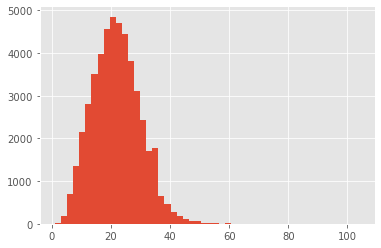

In [41]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [53]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1, random_state=1)


In [54]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding, Dense
from tensorflow.keras.layers import TimeDistributed,SpatialDropout1D,Bidirectional

In [103]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word,out)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

In [105]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [106]:
es = EarlyStopping(monitor="val_accuracy",patience=1, verbose=1, mode="max",restore_best_weights=False)
callbacks = [es]

history = model.fit(x_train,np.array(y_train),
                   validation_split=0.2,
                   batch_size=32,
                   epochs=3)

Epoch 1/3
1080/1080 [==============================] - 465s 430ms/step - loss: 0.1892 - accuracy: 0.9567 - val_loss: 0.0685 - val_accuracy: 0.9804
Epoch 2/3
1080/1080 [==============================] - 459s 425ms/step - loss: 0.0534 - accuracy: 0.9844 - val_loss: 0.0508 - val_accuracy: 0.9847
Epoch 3/3
1080/1080 [==============================] - 462s 427ms/step - loss: 0.0390 - accuracy: 0.9882 - val_loss: 0.0480 - val_accuracy: 0.9856


In [108]:
model.evaluate(x_test,np.array(y_test))

150/150 [==============================] - 5s 36ms/step - loss: 0.0496 - accuracy: 0.9853


[0.04955923557281494, 0.9852835536003113]

In [ ]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis=1)

y_true = np.argmax(np.array(y_test),axis=-1)[i]
print("{:15}{:5}\t".format("Word","True","Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t".format(words[w-1],tags[true],tags[pred]))